In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import networkx as nx
import itertools
import sqlite3

In [2]:
%matplotlib inline

In [3]:
con = sqlite3.connect("data.sqlite")

auth_docu_mod ='''
select authors_id, documents_id, full_name, title
from authors a, documents b, documents_authors c
where a.id=c.authors_id and c.documents_id=b.id;
'''

In [4]:
X = pd.read_sql(auth_docu_mod, con)

X.head()

,authors_id,documents_id,full_name,title
0,1,1,Gerald//Matlin,How to Survive a Management Assessment
1,2,2,A.//Jenkins,What the Information Analyst Should Know About...
2,3,2,Randall//Johnson,What the Information Analyst Should Know About...
3,4,3,Alfonso//Cardenas,Technology for the Automatic Generation of App...
4,5,4,Robert//Bostrom,MIS Problems and Failures: A Socio-Technical P...


In [5]:
Documents = X.documents_id.groupby(by = X.documents_id).size()
print(Documents.head(3))
print(len(Documents))
discribe = Documents.groupby(Documents).size().reset_index()
discribe

documents_id
1    1
2    2
3    1
dtype: int64
1287


,index,0
0,1,353
1,2,537
2,3,299
3,4,76
4,5,13
5,6,6
6,7,2
7,14,1


In [6]:
Authors = X.groupby(by = X.authors_id).size()
print(Authors.head(3))
print(len(Authors))
discribe = Authors.groupby(Authors).size().reset_index()
discribe

authors_id
1    2
2    1
3    1
dtype: int64
1685


,index,0
0,1,1255
1,2,216
2,3,104
3,4,42
4,5,23
5,6,14
6,7,7
7,8,4
8,9,4
9,10,5


In [7]:
all_authors = set(X.authors_id)
len(all_authors)

1685

In [8]:
Y = X["documents_id"].unique()

x = []
y = {}

uniq = Y

len(Y)

1287

In [9]:
for article in uniq:
    y[article] = X.loc[X['documents_id'] == article]['authors_id']
    
len(y)

1287

In [10]:
combinations = []

for article in y:
    g = list(itertools.combinations(y[article], 2))
    for sub in g:
        combinations.append(sub)
len(combinations)


2243

In [11]:
suc_authors = set()
for edge in combinations:
    for auth in edge:
        suc_authors.add(auth)
        
single_dogs= all_authors - suc_authors
print(len(single_dogs))
print(len(suc_authors))
      

118
1567


In [12]:
A_N = X[['authors_id', 'full_name']]
A_N = A_N.drop_duplicates()
A_N.head()

,authors_id,full_name
0,1,Gerald//Matlin
1,2,A.//Jenkins
2,3,Randall//Johnson
3,4,Alfonso//Cardenas
4,5,Robert//Bostrom


In [13]:
A_N.index = A_N.authors_id
A_N.head()

,authors_id,full_name
authors_id,,
1,1,Gerald//Matlin
2,2,A.//Jenkins
3,3,Randall//Johnson
4,4,Alfonso//Cardenas
5,5,Robert//Bostrom


In [14]:
SA_paper_num = Authors.ix[single_dogs]
SA_paper_num.head()

authors_id
1536    1
1       2
4       1
522     1
15      1
dtype: int64

In [15]:
Single_Auth = A_N[A_N.authors_id.isin(single_dogs)]
Single_Auth["paper_num"] = SA_paper_num

Single_Auth.head()

/Users/floyd/Environments/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,authors_id,full_name,paper_num
authors_id,,,
1,1,Gerald//Matlin,2
4,4,Alfonso//Cardenas,1
15,15,Peter//B.,1
19,19,C.W.//Getz,1
20,20,Hugh//Juergens,1


In [16]:
SuA_paper_num = Authors.ix[suc_authors]
SuA_paper_num.head()

Success_Auth = A_N[A_N.authors_id.isin(suc_authors)]
Success_Auth['paper_num'] = SuA_paper_num

Success_Auth.head()

/Users/floyd/Environments/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,authors_id,full_name,paper_num
authors_id,,,
2,2,A.//Jenkins,1
3,3,Randall//Johnson,1
5,5,Robert//Bostrom,5
6,6,J.//Heinen,2
7,7,James//Johnson,1


In [17]:
Edges = Series(combinations)
Edges = Edges.groupby(Edges).size().reset_index()
Edges.rename(columns = {0: 'frequency', "index" : 'Edge'}, inplace = True)
Edges.head()

,Edge,frequency
0,"(2, 3)",1
1,"(5, 6)",2
2,"(5, 222)",2
3,"(5, 223)",2
4,"(7, 8)",1


In [18]:
a = Single_Auth.iloc[0]
print(a)
a.authors_id

authors_id                 1
full_name     Gerald//Matlin
paper_num                  2
Name: 1, dtype: object


1

In [19]:
# 1 with 118
First_Blood = nx.Graph()


for i in range(len(Single_Auth)):
    a = Single_Auth.iloc[i]
    First_Blood.add_node(a.authors_id, full_name =a.full_name, paper_num = a.paper_num)
    


In [20]:

auth1 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==1]
auth2 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==2]
auth3 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==3]
auth4 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] >=4]

In [21]:
# for i in First_Blood.nodes(data = True):
    # print(i)
print(len(auth1))
print(len(auth2))
print(len(auth3))
print(len(auth4))

99
15
3
1


In [22]:
pos = nx.random_layout(First_Blood)

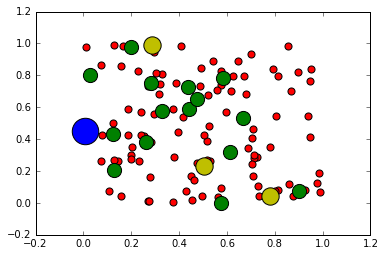

In [23]:
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth1, node_size=50)
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth2, node_size=200, node_color = 'g')
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth3, node_size=300, node_color = 'y')
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth4, node_size=700, node_color = 'b')


In [24]:
G = nx.Graph()

for i in range(len(Success_Auth)):
    a = Success_Auth.iloc[i]
    G.add_node(a.authors_id, full_name =a.full_name, paper_num = a.paper_num)

for i in range(len(Edges)):
    edge = Edges.iloc[i]
    G.add_edge(edge.Edge[0], edge.Edge[1], freq = edge.frequency)

In [25]:
subgraphs = list(nx.connected_component_subgraphs(G))
length = len(subgraphs)
length

294

In [26]:
subgraphs_size = Series()
for i in range(length):
    subgraphs_size.loc[i] = len(subgraphs[i].nodes())
print(subgraphs_size.head())

discribe = subgraphs_size.groupby(subgraphs_size).size().reset_index()
discribe

0      2
1     13
2    721
3      2
4      4
dtype: int64


,index,0
0,2,156
1,3,84
2,4,30
3,5,8
4,6,4
5,7,4
6,8,3
7,10,1
8,11,1
9,12,1


In [27]:

double_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 2 ]
triple_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 3 ]
quadra_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 4 ]

penta_kill  = [ subg for subg in subgraphs 
               if len(subg.nodes()) == 5  or len(subg.nodes()) == 6 ]

rampage     = [ subg for subg in subgraphs 
               if len(subg.nodes()) == 7  or len(subg.nodes()) == 8 ]

godlike     = [ subg for subg in subgraphs 
               if len(subg.nodes()) >= 10 and len(subg.nodes()) < 14]
               
legendary   = [ subg for subg in subgraphs
               if len(subg.nodes()) >= 14 ]

In [28]:
Double_Kill = nx.Graph()
for subg in double_kill:
    Double_Kill.add_edges_from(subg.edges(data = True))
    Double_Kill.add_nodes_from(subg.nodes(data = True))
                   

Triple_Kill = nx.Graph()
for subg in triple_kill:
    Triple_Kill.add_edges_from(subg.edges(data = True))
    Triple_Kill.add_nodes_from(subg.nodes(data = True))

Quadra_Kill = nx.Graph()
for subg in quadra_kill:
    Quadra_Kill.add_edges_from(subg.edges(data = True))
    Quadra_Kill.add_nodes_from(subg.nodes(data = True))

Penta_Kill = nx.Graph()
for subg in penta_kill:
    Penta_Kill.add_edges_from(subg.edges(data = True))
    Penta_Kill.add_nodes_from(subg.nodes(data = True))

Rampage = nx.Graph()
for subg in rampage:
    Rampage.add_edges_from(subg.edges(data = True))
    Rampage.add_nodes_from(subg.nodes(data = True))

Godlike = nx.Graph()
for subg in godlike:
    Godlike.add_edges_from(subg.edges(data = True))
    Godlike.add_nodes_from(subg.nodes(data = True))

Legendary = nx.Graph()
for subg in legendary:
    Legendary.add_edges_from(subg.edges(data = True))
    Legendary.add_nodes_from(subg.nodes(data = True))

In [71]:
def DrawGraph(Achievement, layout = "random"):
    if layout == "random":
        pos = nx.random_layout(Achievement)
    if layout == "shell":
        pos = nx.shell_layout(Achievement)
    if layout == "spring":
        pos = nx.spring_layout(Achievement)
    if layout == "spectral":
        pos = nx.spectral_layout(Achievement)
    
    # for nodes
    auth1 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==1]
    auth2 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==2]
    auth3 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==3]
    auth4 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==4]
    
    
    auth5_10  = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=5  and d["paper_num"] < 11 ]
    auth11_20 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=11 and d["paper_num"] < 21 ]  
    auth21_30 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=21 and d["paper_num"] < 31 ]
    
    auth31_   =  [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=31]
    
    
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth1, node_size=50)
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth2, node_size=100, node_color = 'g')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth3, node_size=200, node_color = 'y')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth4, node_size=300, node_color = 'b')
    
    
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth5_10,  node_size=400, node_color = 'c')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth11_20, node_size=600, node_color = 'm')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth21_30, node_size=800, node_color = 'k')
    
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth31_, node_size=1000, node_color = 'k')
    
    
    # for edges
    edge1 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 1]
    edge2 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 2]
    edge3 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 3]
    
    
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge1, width = 1, edge_color = "grey")
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge2, width = 3,  edge_color = 'b')
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge3, width = 10, edge_color = "m")

    # for labels
    names = {}
    for v, d in Achievement.nodes(data = True):
        names[v] = d["full_name"]
    nx.draw_networkx_labels(Achievement,pos,names,font_size=2, color ="w")



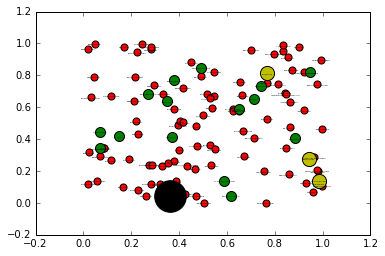

In [73]:
DrawGraph(First_Blood)



In [74]:
plt.close()

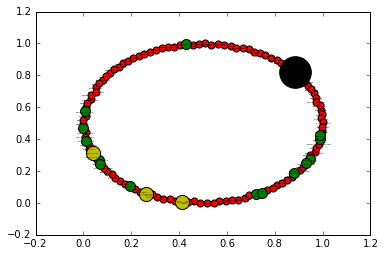

In [75]:
DrawGraph(First_Blood, layout = "spring")

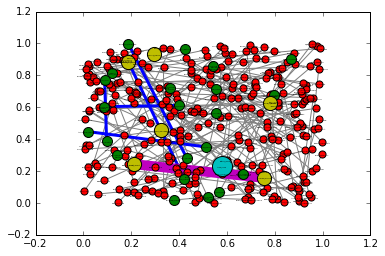

In [76]:
DrawGraph(Double_Kill)

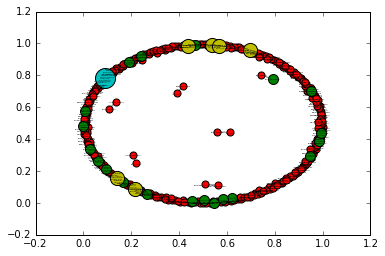

In [77]:
DrawGraph(Double_Kill, layout = "spring")

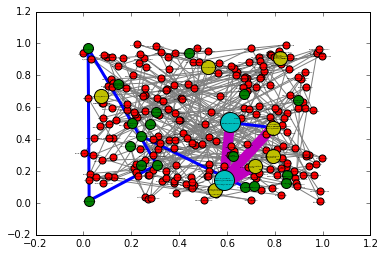

In [78]:
DrawGraph(Triple_Kill)

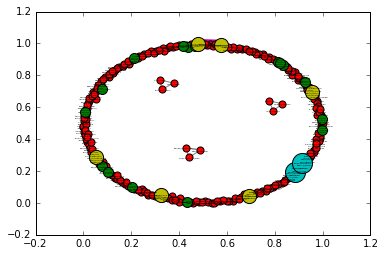

In [79]:
DrawGraph(Triple_Kill, layout = "spring")

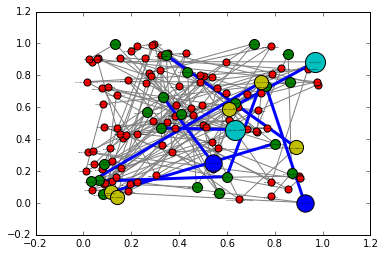

In [80]:
DrawGraph(Quadra_Kill)

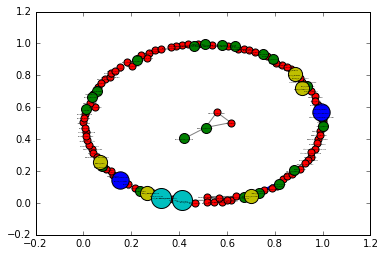

In [81]:
DrawGraph(Quadra_Kill, layout = "spring")

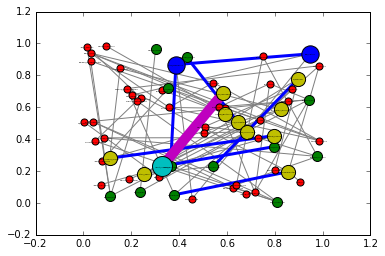

In [82]:
DrawGraph(Penta_Kill)

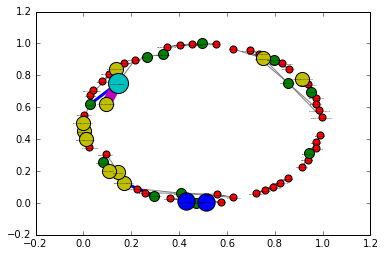

In [83]:
DrawGraph(Penta_Kill, layout = "spring")

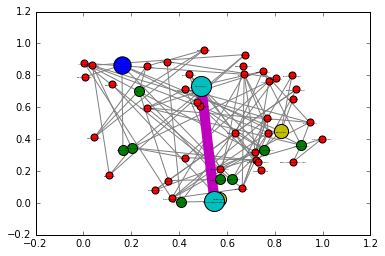

In [84]:
DrawGraph(Rampage)

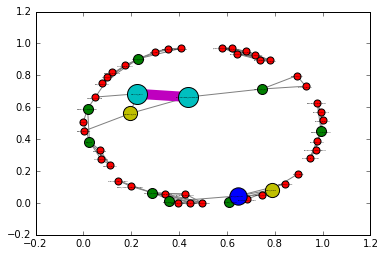

In [85]:
DrawGraph(Rampage, layout = "spring")


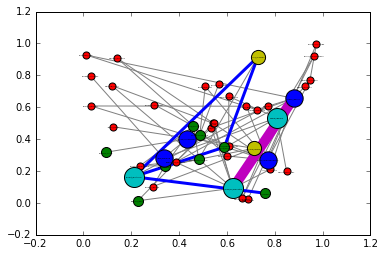

In [86]:
DrawGraph(Godlike)

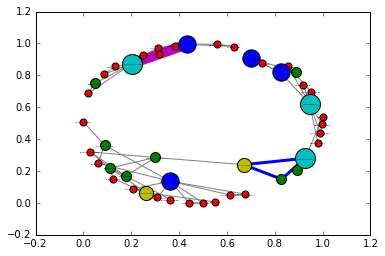

In [87]:
DrawGraph(Godlike, layout = "spring")

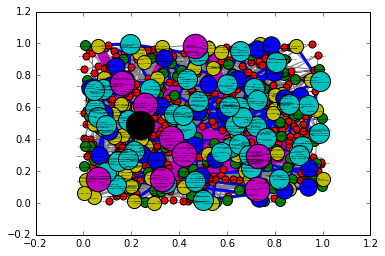

In [88]:
DrawGraph(Legendary)

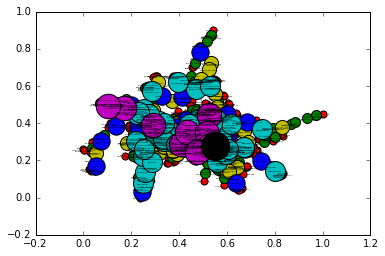

In [89]:
DrawGraph(Legendary, layout = "spring")